In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Decision Tree

Decision Tree is a simple model to explain but a bit harder to program. In essence, it is a flowchart when at every node we ask a question related to one of the features. If the feature is categorical, we ask whether a data point has specific value in that feature; if the feature is ordinal, we can ask if the value is more than or less than some number. We go down that flow chart until we ready to make a guess about our data point.

Here are a few pros of this model:
1. Easy to see how decision is made
2. Can be used as classification or as regression
3. Since we dont compare features with each other, we do not need scaling or normalizing
4. Doesn't care about non-important features (we just dont ask questions about them)

Drawbacks:

1. Tends to overfit.
2. Can get expensive if we try to fix overfit problem

### Intuitive example

Let's upload an example data set and see how we can make a desision tree on it to classify our points.

In [2]:
df = pd.read_csv('DecTreeExample.csv')
df.head()

,length,weight,type
0,8.618381,7.848030,0
1,2.522046,8.762507,0
2,2.035690,7.101971,0
3,6.695008,4.953932,1
4,9.834069,7.908453,0


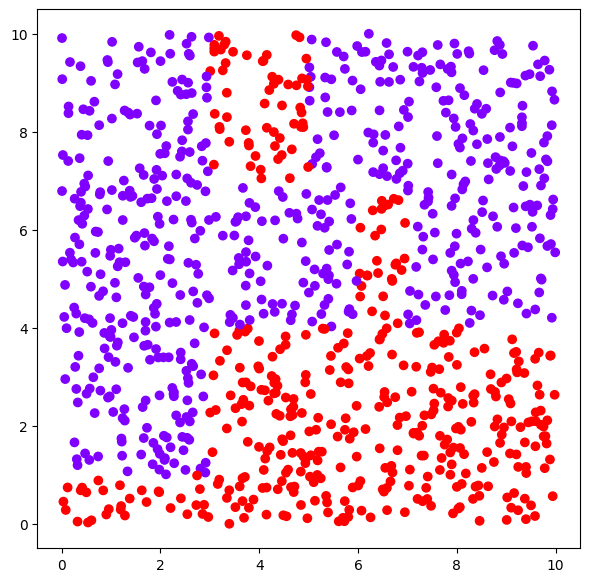

In [3]:
plt.figure(figsize=(7,7))
plt.scatter(df.length, df.weight, c=df.type, cmap='rainbow')
plt.show()

What should be our first question?

Well, we can see that most points with lenght less that about 3 are blue; so we can ask "Is length < 3 ?" This gives us one separation:

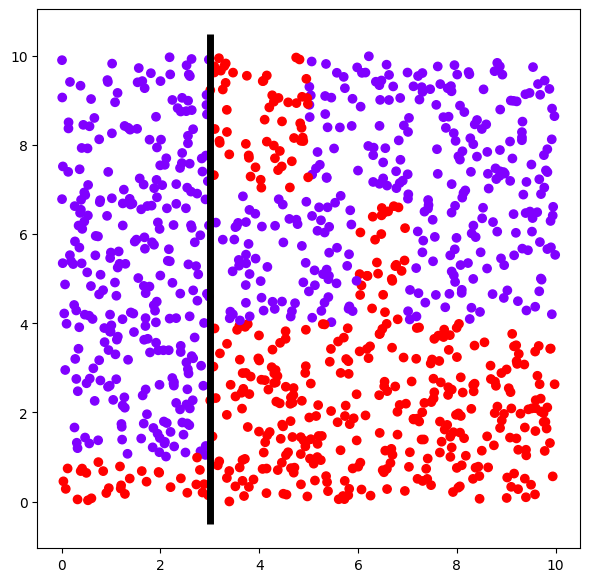

In [4]:
plt.figure(figsize=(7,7))
plt.scatter(df.length, df.weight, c=df.type, cmap='rainbow')
plt.vlines(3, -0.5,10.5,'k',linewidth=5)
plt.show()

Now we can ask another question, but it can depend on what was the answer to the first question:
1. If the answer to the first question was "yes", then we can see that most points are blue, and only a few on the bottom are red. So we can ask "Is the weight < 1 ?" to separate them.
2. If the answer to the first questiuon was "no", then, it's more difficult, but we can maybe ask "Is the weight < 4 ?" to separate those red points.

This will produce someting like this:

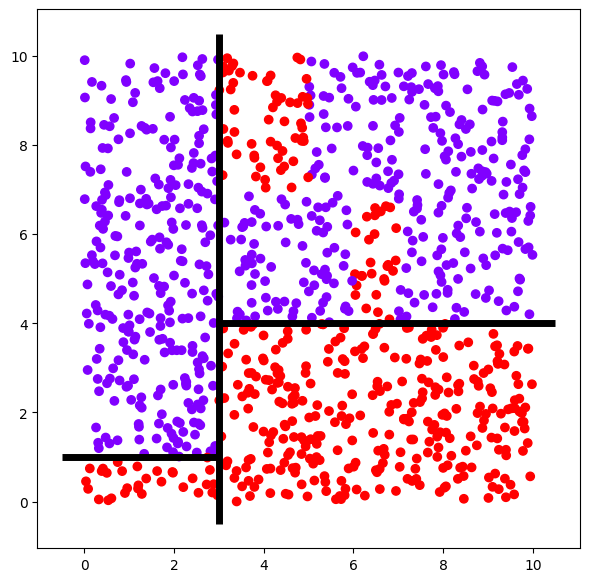

In [5]:
plt.figure(figsize=(7,7))
plt.scatter(df.length, df.weight, c=df.type, cmap='rainbow')
plt.vlines(3, -0.5,10.5,'k',linewidth=5)
plt.hlines(1, -0.5,3,'k',linewidth=5)
plt.hlines(4, 3,10.5,'k',linewidth=5)
plt.show()

We can continue asking questions until we are ready to stop. Our full decision tree in this case may look something like this:


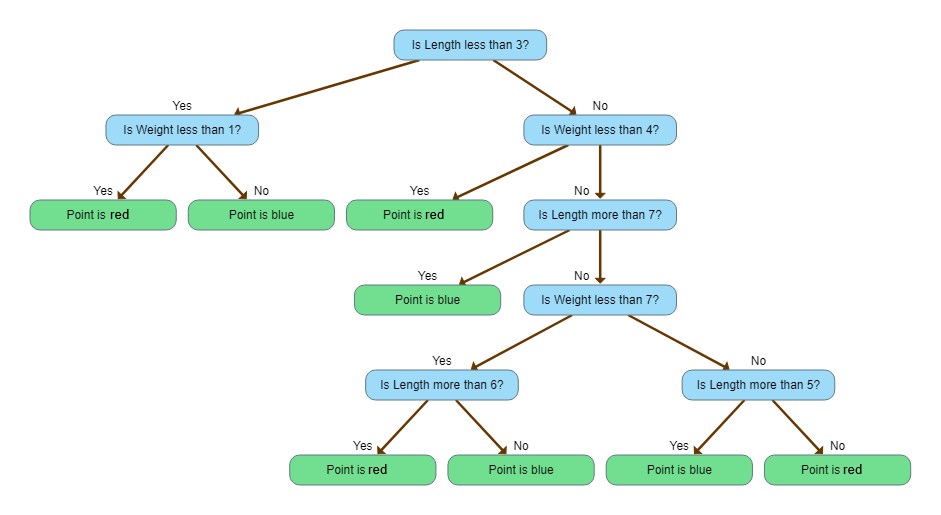

Some terminology:
1. Every box in that picture is called a node.
2. The first node is called Root Node
3. Terminal nodes are called "Leaf Nodes" (green ones)
4. Connection between nodes or a subsection of the tree is called "Branch"
5. A node above a given node is called "Parent"; node below a given node is called "Child"
6. "Depth of the tree" is maximum amount of nodes we can go through from root to  a leaf. (In our example the depth is 5)

So the main things we need to figure out are what questions to ask and when to stop.

### What questions should we ask?

We want to ask such question that gives us the most information. To measure information gain we can use entropy:
$$E=-\sum_{i=1}^Cp_i\log_2(p_i),$$
where $C$ is our classes.
If entropy is 0, we have perfect information. If entropy is 1, have no useful information (choosing a class is the same as randomly guessing). Also note, we are using log based 2 instead of natural log. There is no difference which log we use. This formula comes from information theory where binary system is more in use.

By asking a question we want to improve our entropy (the smaller it is, the better). So given a question we need to compare the entropy we get to entropy of the parent node. To compare our entropies (also called information gain) we subtract old entropy and weighted average of new entropies (weighted by amount of data in each child):
$$Ig=Entropy(parent)-\left(\frac{n_1}{N}Entropy(Child 1)+\frac{n_2}{N}Entropy(Child 2)\right)$$
where $n_1$ and $n_2$ are amount of data in each child, $N$ is amount of data in the parent. Since by asking a question we cannot lose information, $Ig$ is always non-negative.

Let's compute information gain of our first question.

Let's look at our data.

In [11]:
df['type'].value_counts()

,count
type,
0,577
1,423


So we have 1000 data points out of which 577 are blue (zeros) and 423 are red (ones). So our starting entropy is:

In [12]:
Ep=-(577/1000*np.log2(577/1000)+423/1000*np.log2(423/1000))
Ep

0.982824252303905

So, it is almost 1, since we have abit more blue points than red, but it is still close to 50/50. Now lets look at each child and their entropy.

In [13]:
dfyes=df.loc[df.length<3]
dfyes['type'].value_counts()

,count
type,
0,276
1,31


In [14]:
dfno=df.loc[df.length>=3]
dfno['type'].value_counts()

,count
type,
1,392
0,301


In [15]:
E_yes=-((276/307)*np.log2(276/307)+(31/307)*np.log2(31/307))
E_no=-((301/693)*np.log2(301/693)+(392/693)*np.log2(392/693))
E_yes, E_no

(0.4720856085859196, 0.9875257101057102)

In [16]:
Ig=Ep-(307/1000)*E_yes-(693/1000)*E_no
Ig

0.15353865336477057

So this is our information gain. But is it the best we can do? To find out we need to ask all possible questions and compare the answers. Let's quicky do it:

In [17]:
def get_entropy(vals):
    p = np.mean(vals)
    if p==0 or p==1:
        return 0
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

def get_entropy_from_split(df, feature, val):
    left_types = df[df[feature] < val].type
    right_types = df[df[feature] >= val].type

    left_entropy = get_entropy(left_types)
    right_entropy = get_entropy(right_types)

    left_prop = len(left_types) / len(df)
    right_prop = len(right_types) / len(df)

    return left_prop*left_entropy + right_prop*right_entropy

def split(curr_df):
    features = ['length', 'weight']
    best_params = {'feature': None, 'val': None, 'entropy': np.inf}

    for f in features:
        curr = curr_df[f].min()
        step = 0.1
        while curr < curr_df[f].max():
            curr_entropy = get_entropy_from_split(curr_df, f, curr)
            if curr_entropy < best_params['entropy']:
                best_params['feature'] = f
                best_params['val'] = curr
                best_params['entropy'] = curr_entropy
            curr += step
    print(best_params)
    print('Info gain = ', Ep- best_params['entropy'])

curr_df = df.copy()
split(curr_df)

{'feature': 'weight', 'val': 4.001260199577321, 'entropy': 0.6767042417963296}
Info gain =  0.3061200105075754


As you can see, there was a better question: "Is the weight less than 4?" that gives us about 0.3 decrease in entropy.

What is the second two question we should ask?

In [ ]:
curr_df = df.copy()
curr_df = curr_df[(curr_df.weight < 4)]
split(curr_df)

{'feature': 'length', 'val': 2.934902123136255, 'entropy': 0.2300463771367252}
Info gain =  0.7527778751671799


In [ ]:
curr_df = df.copy()
curr_df = curr_df[(curr_df.weight >= 4)]
split(curr_df)

{'feature': 'length', 'val': 3.0065456626365483, 'entropy': 0.5206815915824579}
Info gain =  0.46214266072144716


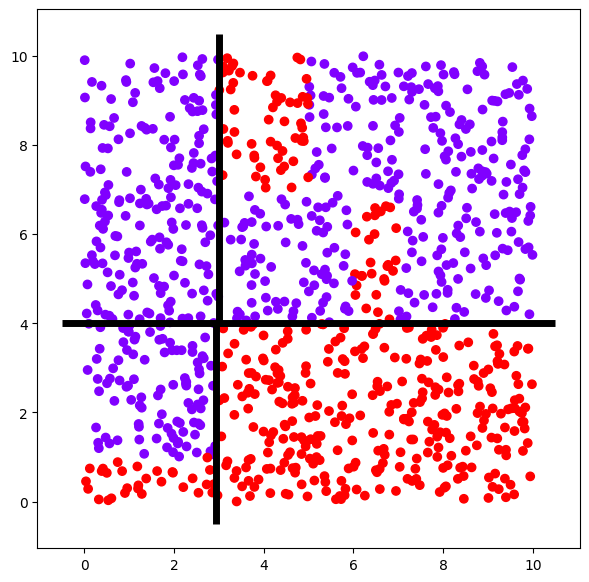

In [18]:
plt.figure(figsize=(7,7))
plt.scatter(df.length, df.weight, c=df.type, cmap='rainbow')
plt.hlines(4, -0.5,10.5,'k',linewidth=5)
plt.vlines(2.93, -0.5,4,'k',linewidth=5)
plt.vlines(3, 4,10.5,'k',linewidth=5)
plt.show()

Let's use sklearn model on this set now

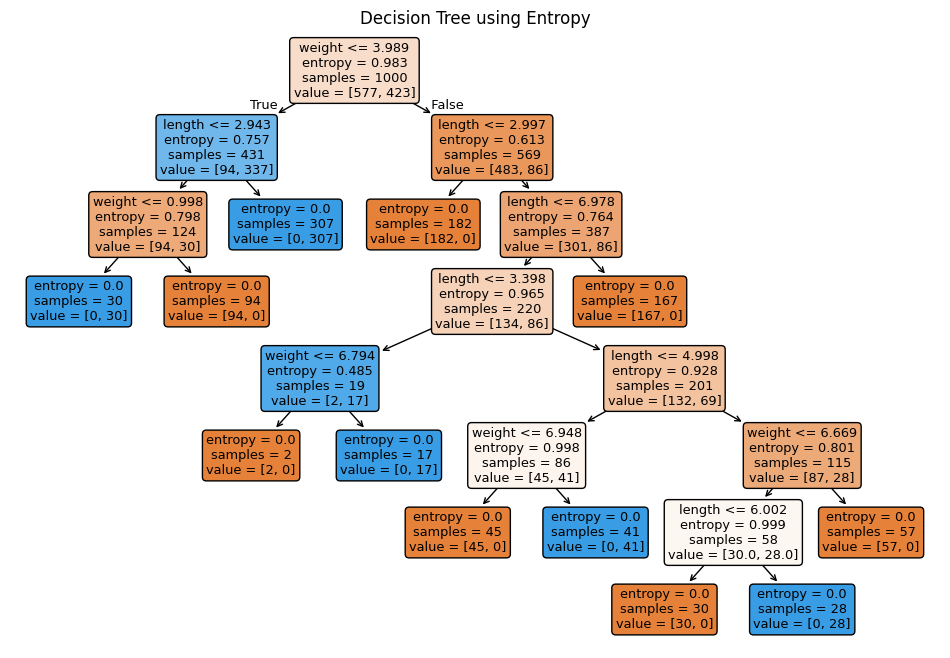

In [19]:
tree_classifier = DecisionTreeClassifier(criterion="entropy")
tree_classifier.fit(df[['length', 'weight']], df['type'])

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier, feature_names=['length', 'weight'], filled=True, rounded=True)
plt.title("Decision Tree using Entropy")
plt.show()

### Gini Index

Another way to figure out what question to ask is to use Gini Index. In essence it calculates the probability of wrongly classifying a randomly chosen data point. Another (and equivalent) way to understand it is Gini Index shows probability that two randomly chosen elements with replacement belong to the different class. If most elements belong to the same class, then it is more likely we can guess their class.

For example, if we have a set $\{b,b,b,r,r,r,r,r,r,r\}$, then the probabilty that we pick two $b$'s is $P(bb)=(3/10)(3/10)=9/100$; and the probability of picking two $r$'s is $P(rr)=(7/10)(7/10)=49/100$. So the probability of having two of the same elements is the sum $P(same)=9/100+49/100=58/100$. Finally, the probability of getting two different elements is $P(different)=1-58/100=42/100=0.42$. This is the Gini Index of our set.

Overall, the formula for Gini Index is $$ Gini=1-\sum_{i=1}^C p_i^2,$$ where $p_i$ is a probability of classifying a data point to a particular class.

Let's use Gini Index to create the Decision tree. If you look carefully, you will see the two trees are not the same.


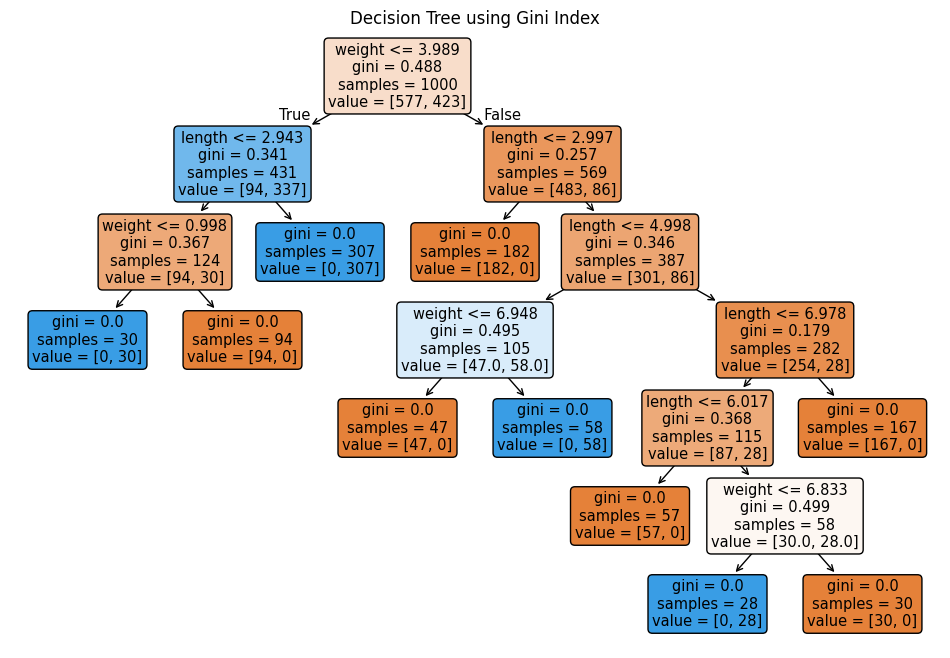

In [20]:
tree_classifier2 = DecisionTreeClassifier(criterion="gini")
tree_classifier2.fit(df[['length', 'weight']], df['type'])

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier2, feature_names=['length', 'weight'], filled=True, rounded=True)
plt.title("Decision Tree using Gini Index")
plt.show()

Let's apply it to Iris Data set and see how it performs.

In [5]:
dataset=datasets.load_iris()
X = dataset.data
y = dataset.target

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

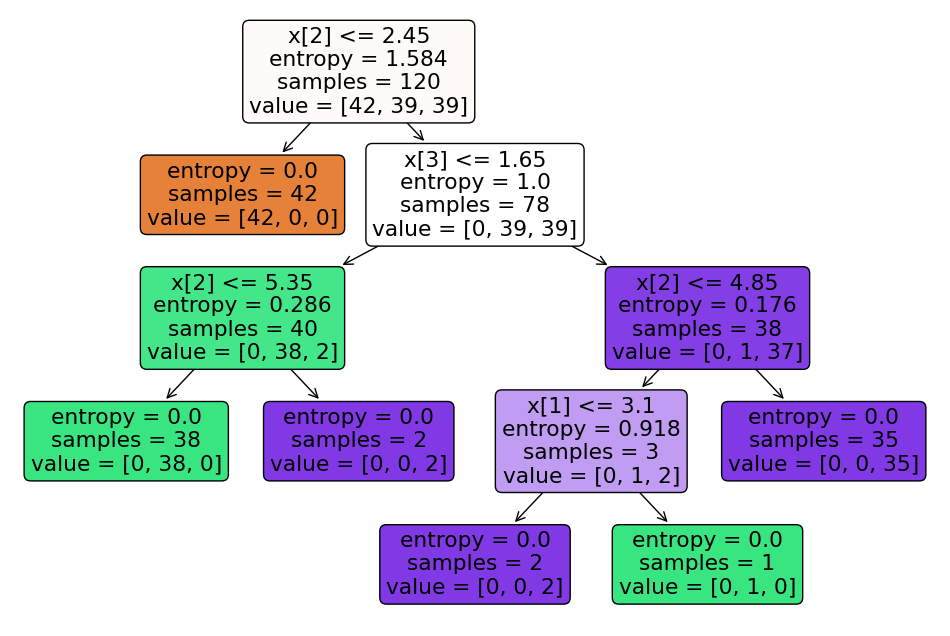

In [9]:
model=DecisionTreeClassifier(criterion="entropy")
model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, rounded=True)

plt.show()

In [11]:
pred=model.predict(X_test)
confusion_matrix(y_test, pred)

array([[ 8,  0,  0],
       [ 0, 10,  1],
       [ 0,  2,  9]], dtype=int64)

### Prunning

If you look carefully at the leaves, you will see that each leave contains only one class. This makes sense, since if a leaf has points belonging to different class, we can subdivide and increase our information gain. This means, if our data set is large, our tree can be quite big and therefore the whole algorithm becomes too expensive. To fix this problem we can use prunning. There are two types of pruning: pre-pruning and post-pruning. Pre-pruning is done as we build the tree and post-pruning is done after the tree is build.

Common pre-prunning techiques are:
1. Set a maximum depth of the tree
2. Set a threshold such that if information gain or Gini Index is less than the threshold we don't split. (minimum impurity)
3. Set a minimum sample size after which we don't split.

Some of the post-pruning techniques:
1. Removing leaves with small sample size.
2. Removing nodes if impurity is below some threshold
3. Removing branches that do  not affect accuracy much

Quick example with one of them:

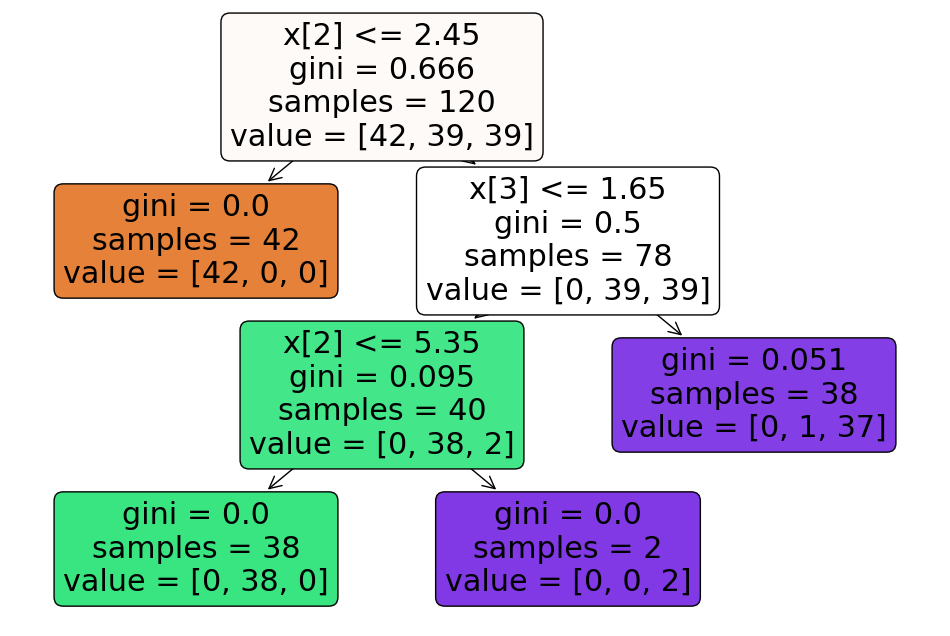

In [17]:
tree_classifier2 = DecisionTreeClassifier(criterion="gini", min_impurity_decrease=0.01, max_depth=3)
tree_classifier2.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(tree_classifier2, filled=True, rounded=True)

plt.show()

In [19]:
pred=tree_classifier2.predict(X_test)
confusion_matrix(y_test, pred)

array([[ 8,  0,  0],
       [ 0, 10,  1],
       [ 0,  2,  9]], dtype=int64)

### Regression

We can use Decision Tree to get regression as well. We still need to find "good" first question. We start in the similar way to classification problem: we go over all features and values to ask questions. In each case we measure "goodness" of the question. Common ways to do that is

1. using MSE between actual data and average of a sample in the split.
2. using SSR: same as MSE except we don't divide by amount od data.
3. using Mean Absolute Error: similar to MSE, except instead of squaring, we take absolute value

Besides this, the problem is similar to classification and we can still apply pre and post pruning.

Here is an example:

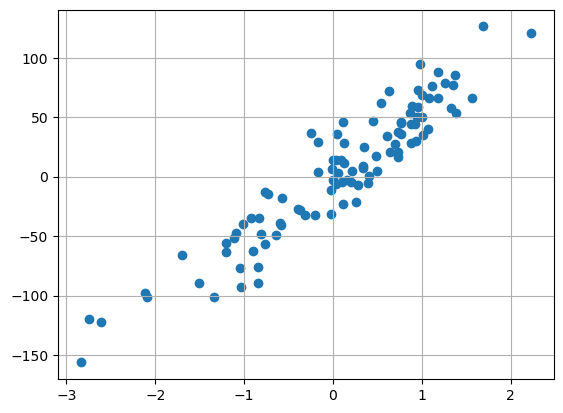

In [ ]:
X, y = datasets.make_regression(n_samples=100, n_features=1, noise=20)

fig=plt.figure()
plt.grid()

plt.scatter(X,y)
plt.show()

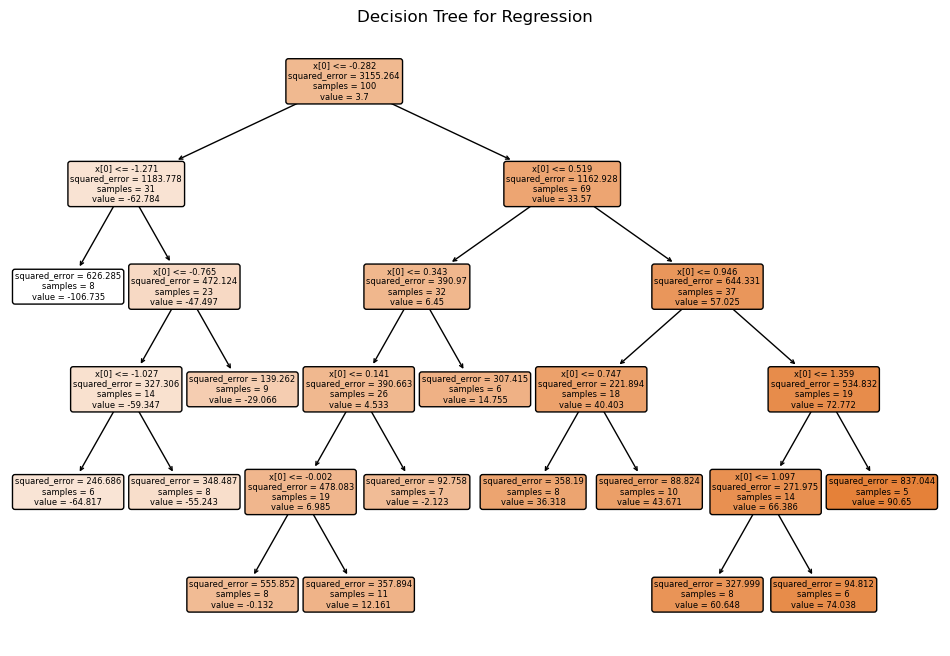

In [ ]:
tree_classifier3 = DecisionTreeRegressor(criterion="squared_error", min_impurity_decrease=1, min_samples_leaf=5)

tree_classifier3.fit(X,y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier3, filled=True, rounded=True)
plt.title("Decision Tree for Regression")
plt.show()

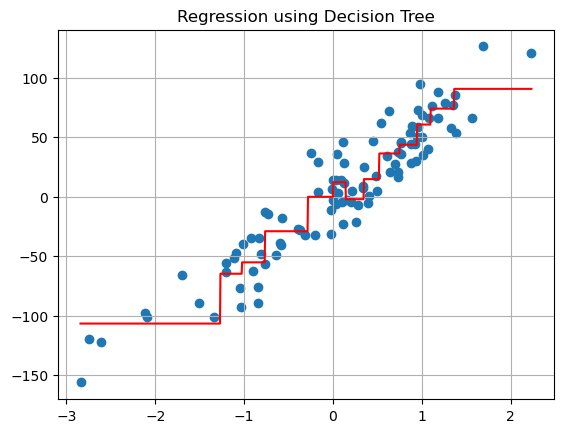

In [ ]:
fig=plt.figure()
xv=np.linspace(X.min(),X.max(), 1000).reshape(-1,1)
plt.grid()
pred=tree_classifier3.predict(xv)
plt.scatter(X,y)
plt.plot(xv, pred, 'r')
plt.title("Regression using Decision Tree")
plt.show()

A small variant of Regression Tree is a Linear Regression tree, where  in each bucket instead of getting constant (the average), we do a linear regression line.